# Project 1: Pre-Code Hollywood Analysis
## Part 1: Loading and Filtering Core Movie Data (1929-1934)

This notebook begins our exploration of Pre-Code Hollywood cinema. Based on the historical context, we are defining the Pre-Code era as films released between **1929** and **1934**, inclusive.

**Objective:**
The goal of this first step is to load the primary dataset containing movie information (`title.basics.tsv`) and filter it down to *only* the movies released in our target era.

**Methodology:**
1.  **Load Data:** We will use the `pandas` library to load the `title.basics.tsv` file into a DataFrame. We must specify that the file is tab-separated (`sep='\t'`) and that the null value indicator is `\N`, as per the IMDb dataset documentation.
2.  **Filter by Type:** The dataset contains all types of titles (e.g., `tvEpisode`, `short`, `videoGame`). We will filter to keep only `titleType == 'movie'`.
3.  **Filter by Year:** We will then apply a date range filter to keep only movies where `startYear` is between 1929 and 1934.
4.  **Verify:** We will inspect the resulting DataFrame's shape, data types (`.info()`), and first few rows (`.head()`) to confirm our filtering was successful.

In [1]:
import pandas as pd
import os

print(f"Pandas version: {pd.__version__}")

# --- 1. Define File Paths ---
# Construct a relative path to our data directory.
# This makes the notebook portable, as it doesn't rely on absolute paths.
DATA_DIR = '../data/raw_imdb'
TITLES_FILE_PATH = os.path.join(DATA_DIR, 'title.basics.tsv')

print(f"Loading data from: {TITLES_FILE_PATH}")

# --- 2. Load the Core Titles Dataset ---
# We use pd.read_csv with a tab separator.
# `na_values='\\N'` correctly interprets IMDb's null value representation.
# `low_memory=False` is used here to prevent a DtypeWarning on loading,
# as pandas might initially see mixed types in some columns of this very large file.
titles_df = pd.read_csv(
    TITLES_FILE_PATH, 
    sep='\t', 
    na_values='\\N',
    low_memory=False
)

print("Successfully loaded title.basics.tsv.")
print("-" * 30)


# --- 3. Apply Filters for Pre-Code Movies ---
print("Filtering for Pre-Code era movies (1929-1934)...")

# Filter 1: Keep only rows where titleType is 'movie'.
is_movie = titles_df['titleType'] == 'movie'

# Filter 2: Keep only rows where startYear is between 1929 and 1934.
# .between() is an efficient and readable way to do this.
is_pre_code_era = titles_df['startYear'].between(1929, 1934, inclusive='both')

# Combine the filters and create a new DataFrame.
# Using .copy() is important here to avoid a SettingWithCopyWarning from pandas later.
# This explicitly tells pandas we are creating a new, independent DataFrame.
pre_code_movies_df = titles_df[is_movie & is_pre_code_era].copy()


# --- 4. Verify the Filtered Data ---
print(f"Found {pre_code_movies_df.shape[0]:,} movies from the Pre-Code era.")
print("\nDataFrame Info:")
pre_code_movies_df.info()

print("\nFirst 5 rows of the filtered DataFrame:")
# In a Jupyter Notebook, display() provides a nicer HTML table format than print().
display(pre_code_movies_df.head())

Pandas version: 2.1.4
Loading data from: ../data/raw_imdb/title.basics.tsv
Successfully loaded title.basics.tsv.
------------------------------
Filtering for Pre-Code era movies (1929-1934)...
Found 12,442 movies from the Pre-Code era.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 12442 entries, 14911 to 11825202
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          12442 non-null  object 
 1   titleType       12442 non-null  object 
 2   primaryTitle    12442 non-null  object 
 3   originalTitle   12442 non-null  object 
 4   isAdult         12442 non-null  float64
 5   startYear       12442 non-null  float64
 6   endYear         0 non-null      float64
 7   runtimeMinutes  6394 non-null   object 
 8   genres          9677 non-null   object 
dtypes: float64(3), object(6)
memory usage: 972.0+ KB

First 5 rows of the filtered DataFrame:


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
14911,tt0015152,movie,Mustalaishurmaaja,Mustalaishurmaaja,0.0,1929.0,NaN,69,"Drama,Romance"
15787,tt0016035,movie,El lobo,El lobo,0.0,1929.0,NaN,NaN,NaN
17315,tt0017578,movie,The Wrecker,The Wrecker,0.0,1929.0,NaN,74,"Crime,Drama"
17589,tt0017853,movie,Las estrellas,Las estrellas,0.0,1930.0,NaN,NaN,NaN
17801,tt0018069,movie,La del Soto del Parral,La del Soto del Parral,0.0,1929.0,NaN,NaN,NaN


## Part 2: Loading and Merging Personnel Data

Now that we have a clean list of Pre-Code movies, our goal is to identify the **actors, actresses, directors, and writers** associated with them. To do this, we need to load the other IMDb datasets and merge them with our `pre_code_movies_df`.

**Objective:**
Create a single, comprehensive DataFrame that links each Pre-Code movie (`tconst`) to the principal cast/crew members (`nconst`) and their names (`primaryName`).

**Methodology: An Efficient Approach 🧠**
The personnel files (`title.principals.tsv`, `title.crew.tsv`) are enormous, containing data for millions of titles. Loading and then merging these entire files would be very slow and memory-intensive.

A more professional and efficient strategy is to **pre-filter** the personnel data *before* the merge:
1.  **Extract Keys:** Get the unique `tconst` identifiers from our already-filtered `pre_code_movies_df`.
2.  **Filter Personnel Data:** Use these keys to select only the rows from `title.principals` and `title.crew` that match our Pre-Code movies. This drastically reduces the amount of data we need to process.
3.  **Load Name Data:** Load the `name.basics` file, which maps the `nconst` identifiers to actual names.
4.  **Merge:** Perform a series of `left` joins to combine the datasets, ensuring we keep all our Pre-Code movies as the foundation.
5.  **Clean-Up:** Perform minor data type conversions for clarity (e.g., converting `startYear` from a float to an integer).

In [2]:
# --- 1. Define Paths for Additional Files ---
PRINCIPALS_FILE_PATH = os.path.join(DATA_DIR, 'title.principals.tsv')
NAMES_FILE_PATH = os.path.join(DATA_DIR, 'name.basics.tsv')
CREW_FILE_PATH = os.path.join(DATA_DIR, 'title.crew.tsv')

# --- 2. Load the Additional Datasets ---
print("Loading personnel datasets...")
principals_df = pd.read_csv(PRINCIPALS_FILE_PATH, sep='\t', na_values='\\N')
names_df = pd.read_csv(NAMES_FILE_PATH, sep='\t', na_values='\\N')
# crew_df = pd.read_csv(CREW_FILE_PATH, sep='\t', na_values='\\N') # We can load this later if we focus on writers
print("Personnel datasets loaded.")
print("-" * 30)


# --- 3. Pre-filter `principals_df` for Efficiency ---
# Get the set of unique tconsts from our filtered movie list. Using a set is very fast for lookups.
pre_code_tconsts = set(pre_code_movies_df['tconst'])

print(f"Original size of principals DataFrame: {len(principals_df):,}")

# Keep only the rows in principals_df that correspond to our Pre-Code movies.
pre_code_principals_df = principals_df[principals_df['tconst'].isin(pre_code_tconsts)].copy()

print(f"Filtered size of principals DataFrame: {len(pre_code_principals_df):,}")
print("-" * 30)


# --- 4. Merge the DataFrames ---
print("Merging DataFrames...")

# Step A: Merge our movies list with the filtered principals list.
# A 'left' join ensures we keep all movies from our original pre_code_movies_df.
merged_df = pd.merge(pre_code_movies_df, pre_code_principals_df, on='tconst', how='left')

# Step B: Merge the result with the names list to get the person's name.
# This links the 'nconst' from the principals data to the 'primaryName' in the names data.
final_df = pd.merge(merged_df, names_df, on='nconst', how='left')
print("Merging complete.")
print("-" * 30)


# --- 5. Final Cleaning and Verification ---
# Convert float year to integer for cleaner display. We can do this now as the NaNs are gone.
final_df['startYear'] = final_df['startYear'].astype(int)

# Drop columns we don't need for this analysis to save memory and improve clarity.
columns_to_drop = ['endYear', 'titleType', 'isAdult', 'job', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles']
final_df = final_df.drop(columns=columns_to_drop)


print("Final DataFrame Info:")
final_df.info()

print("\nFirst 10 rows of the final combined DataFrame:")
display(final_df.head(10))

Loading personnel datasets...
Personnel datasets loaded.
------------------------------
Original size of principals DataFrame: 94,044,797
Filtered size of principals DataFrame: 137,760
------------------------------
Merging DataFrames...
Merging complete.
------------------------------
Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138287 entries, 0 to 138286
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          138287 non-null  object 
 1   primaryTitle    138287 non-null  object 
 2   originalTitle   138287 non-null  object 
 3   startYear       138287 non-null  int64  
 4   runtimeMinutes  97436 non-null   object 
 5   genres          115286 non-null  object 
 6   ordering        137760 non-null  float64
 7   nconst          137760 non-null  object 
 8   category        137760 non-null  object 
 9   characters      61109 non-null   object 
 10  primaryName     137759 

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,ordering,nconst,category,characters,primaryName
0,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",1.0,nm0876343,actor,"[""Manjardo""]",Teuvo Tulio
1,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",2.0,nm0352586,actress,"[""Esmeralda""]",Meri Hackzell
2,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",3.0,nm0846833,actress,"[""Akris""]",Hanna Taini
3,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",4.0,nm0726958,actress,"[""Glafira""]",Alli Riks
4,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",5.0,nm0491540,actor,"[""Feri""]",Bruno Laurén
5,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",6.0,nm0937436,actor,"[""Iska""]",Waldemar Wohlin
6,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",7.0,nm10246489,actor,NaN,Aarne Bollström
7,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",8.0,nm10246490,actress,NaN,Ester Hagert
8,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",9.0,nm3638732,actress,NaN,Hemmi Hagert
9,tt0015152,Mustalaishurmaaja,Mustalaishurmaaja,1929,69,"Drama,Romance",10.0,nm10246488,actor,NaN,Aarne Isberg


## Part 3: Initial Analysis & Visualization

With our unified dataset, we can now begin to answer some fundamental questions about the Pre-Code era. The goal here is to perform aggregations and create simple visualizations to understand the landscape of Hollywood from 1929-1934.

**Analysis Questions:**
1.  Who were the most **prolific directors** of this era?
2.  Who were the most frequently appearing **actors and actresses**?
3.  What were the most **common genres**?

**Methodology:**
* **Aggregation:** We will use the `.value_counts()` method to count occurrences of names and genres.
* **Data Cleaning (on-the-fly):** The `genres` column contains comma-separated strings (e.g., `"Drama,Romance"`). To analyze this properly, we will split these strings into lists and then use the `.explode()` method to create a new row for each individual genre, allowing for accurate counting.
* **Visualization:** We will use `matplotlib` and `seaborn` to create simple, clear bar charts to present our findings.

--- Top 10 Most Prolific Directors (Global, 1929-1934) ---
primaryName
Hôzô Nakajima      69
Taizan Gotô        62
Kôji Oka           56
J.P. McGowan       54
Carl Boese         51
Minoru Ishiyama    47
Richard Thorpe     46
Misao Yoshimura    46
Shiroku Nagao      45
Karel Lamac        44
Name: count, dtype: int64
--------------------------------------------------
--- Top 15 Most Prolific Actors/Actresses (Global, 1929-1934) ---
primaryName
Itoji Koto            84
Akane Hisano          84
Julius Falkenstein    83
Lafe McKee            83
Utaemon Ichikawa      80
Futaba Kinoshita      79
Ayako Chiyoda         74
Komako Hara           72
Fritz Kampers         71
Kanjûrô Arashi        69
Kikuko Tachibana      68
Paul Hörbiger         68
Ida Wüst              67
Zasu Pitts            67
Reiko Harumi          64
Name: count, dtype: int64
--------------------------------------------------

--- Top 15 Most Common Genres (Global, 1929-1934) ---
genre
Drama          6086
Comedy         2150
R

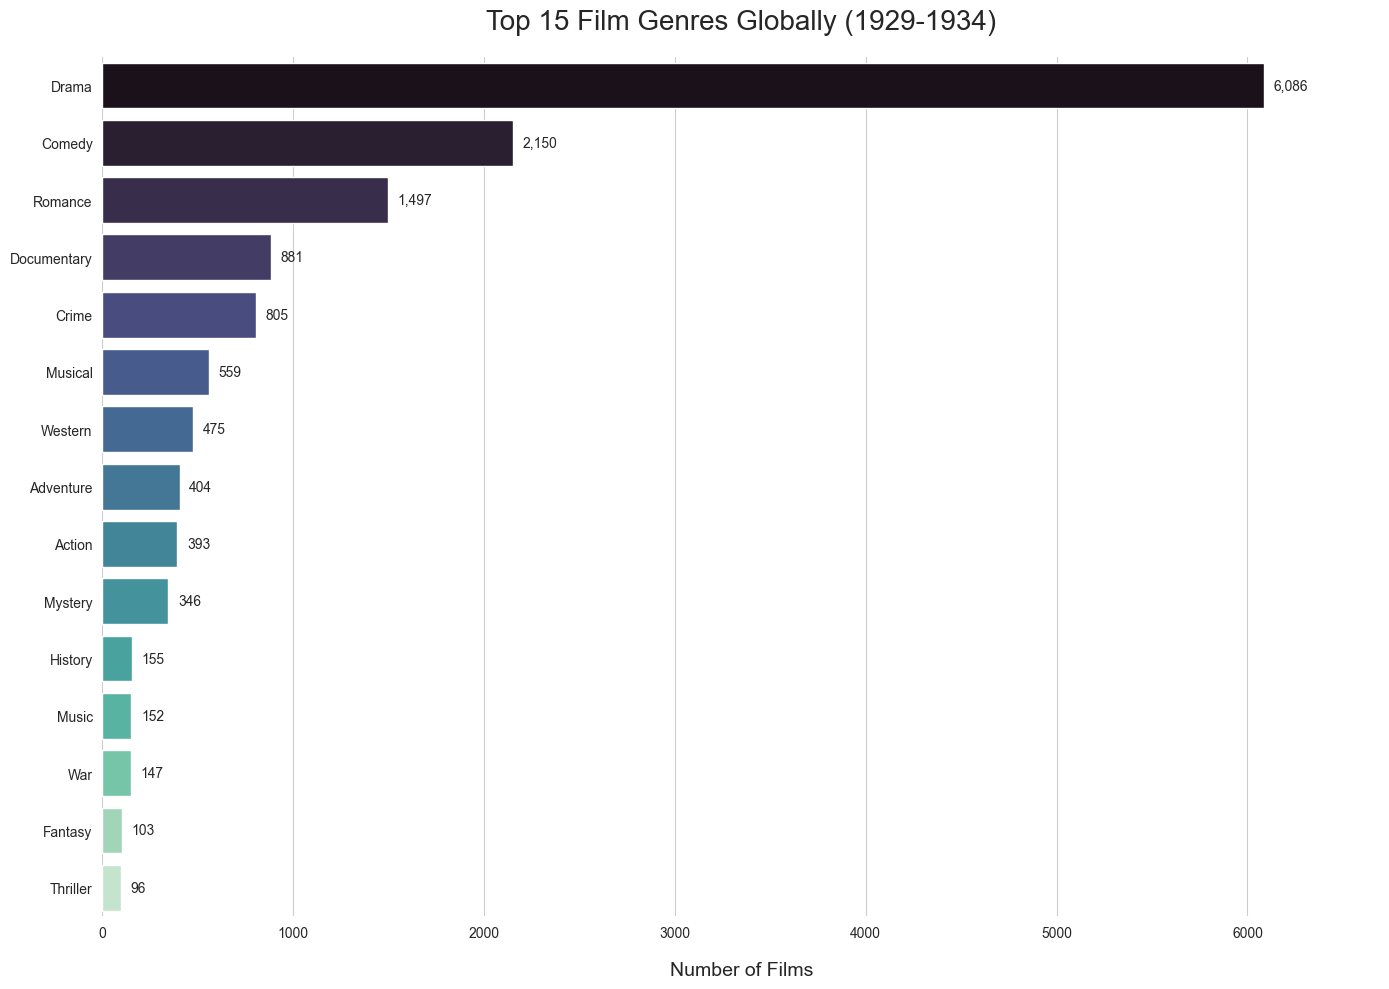

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Analysis: Most Prolific Directors ---
directors_df = final_df[final_df['category'] == 'director']
top_directors = directors_df['primaryName'].value_counts().head(10)
print("--- Top 10 Most Prolific Directors (Global, 1929-1934) ---")
print(top_directors)
print("-" * 50)

# --- 2. Analysis: Most Prolific Actors & Actresses ---
actors_df = final_df[final_df['category'].isin(['actor', 'actress'])]
top_actors = actors_df['primaryName'].value_counts().head(15)
print("--- Top 15 Most Prolific Actors/Actresses (Global, 1929-1934) ---")
print(top_actors)
print("-" * 50)

# --- 3. Analysis: Most Common Genres ---
genres_df = final_df.dropna(subset=['genres'])
unique_movie_genres = genres_df.drop_duplicates(subset=['tconst'])[['tconst', 'genres']]
genres_exploded = unique_movie_genres.assign(genre=unique_movie_genres['genres'].str.split(',')).explode('genre')
top_genres = genres_exploded['genre'].value_counts().head(15)
print("\n--- Top 15 Most Common Genres (Global, 1929-1934) ---")
print(top_genres)


# --- 4. Professional Visualization: Top Genres ---

# Use the object-oriented approach (fig, ax) for more control over the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Create the barplot on the specified axes (ax)
# FIX: Assign 'y' to 'hue' to map colors to genres and set dodge=False.
# This resolves the FutureWarning and ensures bars are not shifted.
sns.barplot(
    x=top_genres.values,
    y=top_genres.index,
    hue=top_genres.index, # Assigning hue to fix warning
    palette="mako",      # Using a new, professional color palette
    dodge=False,         # Prevent bars from shifting
    ax=ax
)

# Add data labels to each bar for clarity
for bar in ax.patches:
    # Get the bar's width (the value) and position
    width = bar.get_width()
    # Position the text label slightly after the bar
    ax.text(
        width + 50, # Add a small offset from the bar end
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}', # Format number with a comma for thousands
        va='center', # Vertically align text to the center of the bar
        ha='left'    # Horizontally align text to the left
    )

# --- Refine Aesthetics ---
ax.set_title('Top 15 Film Genres Globally (1929-1934)', fontsize=20, pad=20)
ax.set_xlabel('Number of Films', fontsize=14, labelpad=15)
ax.set_ylabel('') # The y-axis labels are self-explanatory, so we remove the "Genre" title

# Remove the legend, as it's redundant when each bar is a unique category

# Set a higher limit for the x-axis to make space for the labels on the longest bar
ax.set_xlim(0, top_genres.max() * 1.1)

# Remove the top and right spines for a cleaner look
sns.despine(left=True, bottom=True)

# Ensure the layout is tight and all elements are visible
plt.tight_layout()
plt.show()

## Part 5: Refining the Dataset for "Hollywood" Productions

Our initial analysis revealed that our dataset is global. To focus on **Pre-Code Hollywood**, we need to filter our films to include only those produced in the United States. We will use the newly downloaded `title.akas.tsv` file, which contains regional information for each title.

**Methodology:**
1.  **Load Regional Data:** Load `title.akas.tsv` into a new DataFrame.
2.  **Filter for US Region:** Select only the rows where the `region` column is `'US'`.
3.  **Extract US Title Keys:** Create a `set` of unique `tconst` values from these US-only titles for a highly efficient filter.
4.  **Apply Filter:** Use this set to filter our main `final_df`, creating a new `hollywood_df` that contains only data for US productions.

In [10]:
# --- 1. Load the Title AKAs (Regional) Data ---
AKAS_FILE_PATH = os.path.join(DATA_DIR, 'title.akas.tsv')
print("Loading regional data from title.akas.tsv...")
akas_df = pd.read_csv(AKAS_FILE_PATH, sep='\t', na_values='\\N', usecols=['titleId', 'region'])
# We only need 'titleId' (the tconst) and 'region', so we use 'usecols' to save memory.
akas_df.rename(columns={'titleId': 'tconst'}, inplace=True) # Rename for consistency

# --- 2. Filter for US Productions ---
us_akas_df = akas_df[akas_df['region'] == 'US']

# --- 3. Extract Unique tconsts for US Titles ---
# A set provides very fast membership checking.
us_tconst_set = set(us_akas_df['tconst'])
print(f"Found {len(us_tconst_set):,} unique US titles in the AKAs dataset.")

# --- 4. Filter Our Main DataFrame ---
print(f"Original merged DataFrame size: {len(final_df):,}")
hollywood_df = final_df[final_df['tconst'].isin(us_tconst_set)].copy()
print(f"New Hollywood-only DataFrame size: {len(hollywood_df):,}")

# --- 5. Verify the result ---
print("\nFirst 5 rows of the Hollywood-only DataFrame:")
display(hollywood_df.head())

Loading regional data from title.akas.tsv...
Found 1,548,583 unique US titles in the AKAs dataset.
Original merged DataFrame size: 138,287
New Hollywood-only DataFrame size: 69,272

First 5 rows of the Hollywood-only DataFrame:


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,ordering,nconst,category,characters,primaryName
32,tt0017578,The Wrecker,The Wrecker,1929,74,"Crime,Drama",1.0,nm0085877,actor,"[""Ambrose Barney""]",Carlyle Blackwell
33,tt0017578,The Wrecker,The Wrecker,1929,74,"Crime,Drama",2.0,nm0401729,actress,"[""Mary Shelton""]",Benita Hume
34,tt0017578,The Wrecker,The Wrecker,1929,74,"Crime,Drama",3.0,nm0834504,actor,"[""Roger Doyle""]",Joseph Striker
35,tt0017578,The Wrecker,The Wrecker,1929,74,"Crime,Drama",4.0,nm0356228,actor,"[""Sir Gerald Bartlett""]",Winter Hall
36,tt0017578,The Wrecker,The Wrecker,1929,74,"Crime,Drama",5.0,nm0363104,actor,"[""William""]",Gordon Harker


## Part 6: Refactoring into a Reusable Analysis Function

Before proceeding, we will refactor our analysis code into a reusable function. In programming, this follows the **DRY (Don't Repeat Yourself)** principle. Creating a function is a professional practice that provides several key benefits:

**Objective:**
To encapsulate our analysis and plotting logic into a single, reusable function that can be called on any DataFrame.

**Methodology & Benefits:**
1.  **Reusability:** We can now run the exact same analysis on different data subsets (like our `global_df` vs. our `hollywood_df`) without copying and pasting code.
2.  **Consistency:** Ensures that the analysis and visualizations are performed identically each time, making results comparable.
3.  **Maintainability:** If we need to update the logic or fix a bug (like the `AttributeError` we found), we only need to change it in one place—the function definition.

The function `analyze_and_plot_top_N` was created to perform these steps and was used to generate the final, corrected analysis of the Hollywood-specific data.


--- Analysis for Hollywood Productions ---

--- Top 10 Most Prolific Directors (Hollywood) ---
primaryName
J.P. McGowan         53
Richard Thorpe       46
Phil Rosen           40
Frank R. Strayer     32
Lloyd Bacon          31
William A. Seiter    30
Michael Curtiz       29
Mervyn LeRoy         29
Carl Boese           28
D. Ross Lederman     27
Name: count, dtype: int64

--- Top 15 Most Prolific Actors/Actresses (Hollywood) ---
primaryName
Lafe McKee              83
Zasu Pitts              67
Oscar Apfel             63
John Miljan             60
J. Farrell MacDonald    56
Henry Armetta           55
Berton Churchill        54
Noah Beery              51
Richard Tucker          49
Edmund Breese           48
Tom London              48
Ernie Adams             47
Frank McHugh            47
Myrna Loy               47
Henry B. Walthall       46
Name: count, dtype: int64

--- Top 15 Most Common Genres (Hollywood) ---
genre
Drama          2798
Comedy         1291
Romance        1225
Crime      

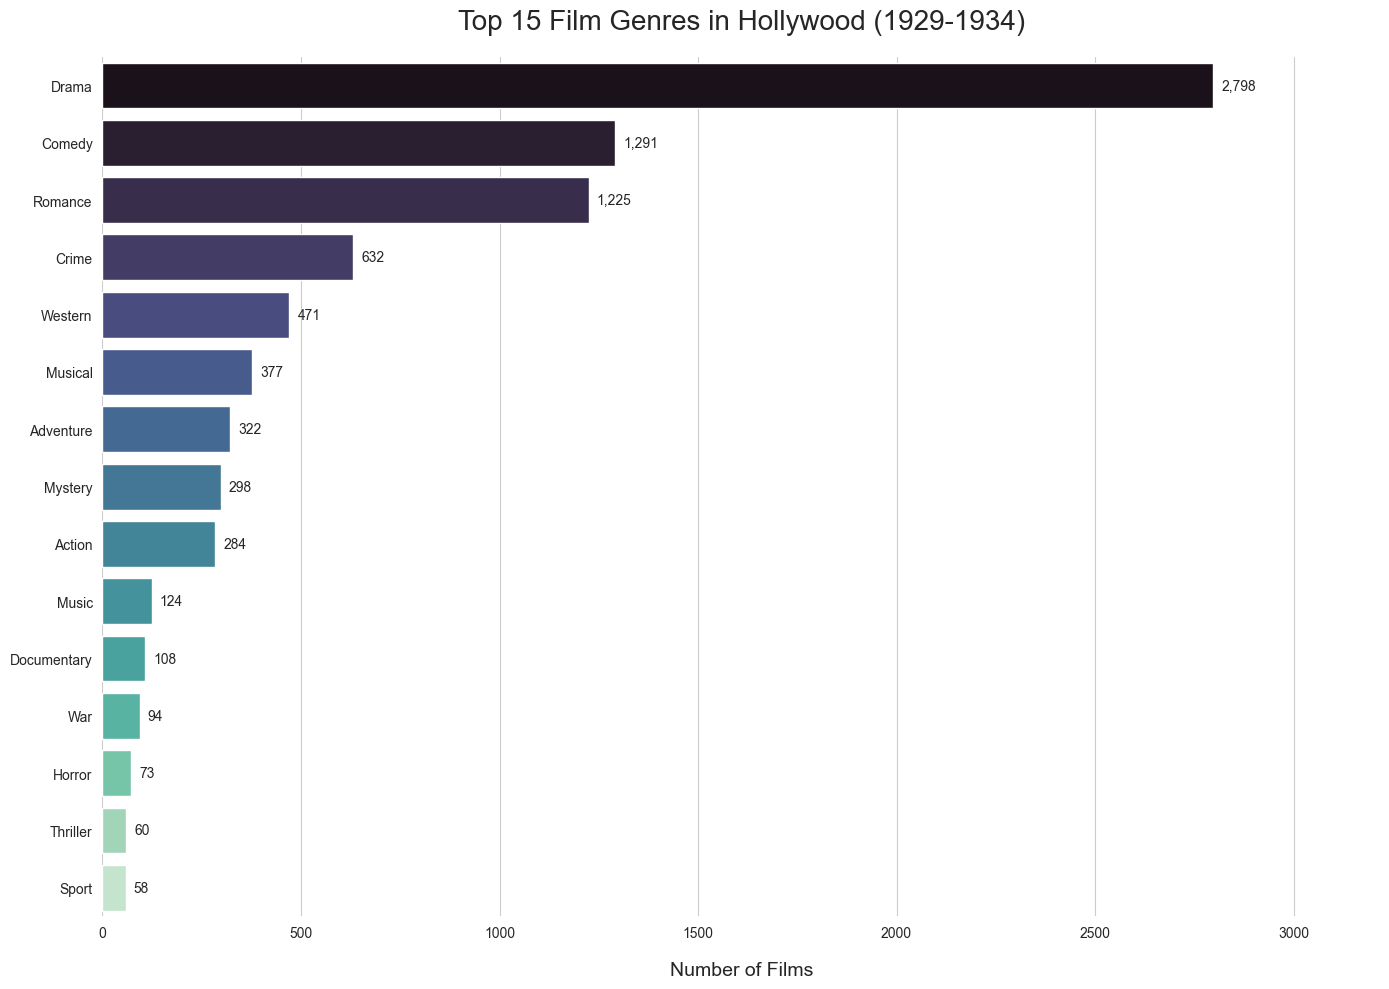

In [12]:
def analyze_and_plot_top_N(dataframe, title_suffix=""):
    """
    Performs analysis and visualization on a given film dataframe.
    Calculates top directors, actors, and genres, then plots the top genres.
    
    Args:
        dataframe (pd.DataFrame): The dataframe to analyze.
        title_suffix (str): A string to append to plot titles (e.g., 'Hollywood').
    """
    print(f"\n--- Analysis for {title_suffix} Productions ---")

    # Analysis: Directors
    directors = dataframe[dataframe['category'] == 'director']['primaryName'].value_counts().head(10)
    print(f"\n--- Top 10 Most Prolific Directors ({title_suffix}) ---")
    print(directors)

    # Analysis: Actors
    actors = dataframe[dataframe['category'].isin(['actor', 'actress'])]['primaryName'].value_counts().head(15)
    print(f"\n--- Top 15 Most Prolific Actors/Actresses ({title_suffix}) ---")
    print(actors)

    # Analysis: Genres
    genres_unique = dataframe.dropna(subset=['genres']).drop_duplicates(subset=['tconst'])
    genres_exploded = genres_unique.assign(genre=genres_unique['genres'].str.split(',')).explode('genre')
    top_genres = genres_exploded['genre'].value_counts().head(15)
    print(f"\n--- Top 15 Most Common Genres ({title_suffix}) ---")
    print(top_genres)

    # Visualization: Genres
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.barplot(x=top_genres.values, y=top_genres.index, hue=top_genres.index, palette="mako", dodge=False, ax=ax)
    
    for bar in ax.patches:
        width = bar.get_width()
        ax.text(width + 20, bar.get_y() + bar.get_height() / 2, f'{int(width):,}', va='center', ha='left')

    ax.set_title(f'Top 15 Film Genres in {title_suffix} (1929-1934)', fontsize=20, pad=20)
    ax.set_xlabel('Number of Films', fontsize=14, labelpad=15)
    ax.set_ylabel('')
    
    # The legend is not created by default in this specific plot, so the line to remove it is unnecessary.
    
    ax.set_xlim(0, top_genres.max() * 1.15)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# Now, run the analysis on our new Hollywood-specific DataFrame
analyze_and_plot_top_N(hollywood_df, title_suffix="Hollywood")

## Part 7: Thematic Deep Dive - Horror, Sci-Fi, and Comedy

Now that we have a clean, Hollywood-focused dataset, we can perform a more granular analysis. Our goal is to isolate the films within our three target genres—**Horror**, **Sci-Fi**, and **Comedy**—and identify the most prolific creative personnel within each.

**Methodology:**
1.  **Identify Target Films:** We will reuse our `genres_exploded` DataFrame, which conveniently lists every genre for every unique film. We will filter this to get the `tconst` identifiers for all films tagged with our target genres.
2.  **Isolate Genre Data:** For each genre, we will use its list of `tconst`s to filter our main `hollywood_df`. This will create dedicated DataFrames (e.g., `hollywood_horror_df`).
3.  **Analyze Subsets:** We will analyze each of these genre-specific DataFrames to find the top 5 directors and top 10 actors/actresses, revealing the specialists of the era.

In [13]:
# --- 1. Identify Target Genres and Get Relevant Movie IDs ---

# We already have 'genres_exploded' from our previous steps.
# It contains one row for each genre a movie has.
print(f"Total unique movie-genre combinations: {len(genres_exploded):,}")

# Define the genres we want to investigate
target_genres = ['Horror', 'Sci-Fi', 'Comedy']

# Filter the exploded genre list to get only the rows with our target genres
thematic_genres_df = genres_exploded[genres_exploded['genre'].isin(target_genres)]

print(f"Found {len(thematic_genres_df):,} movie-genre combinations for Horror, Sci-Fi, and Comedy.")


# --- 2. Create a Reusable Function for Genre-Specific Analysis ---

def analyze_specific_genre(genre_name, source_df, thematic_df):
    """
    Analyzes and prints the top directors and actors for a specific genre.

    Args:
        genre_name (str): The genre to analyze (e.g., 'Horror').
        source_df (pd.DataFrame): The main hollywood_df containing all person data.
        thematic_df (pd.DataFrame): The filtered dataframe containing only tconsts for target genres.
    """
    print(f"\n{'='*20} Analysis for: {genre_name} {'='*20}")

    # Get the unique tconsts for the specific genre
    genre_tconsts = set(thematic_df[thematic_df['genre'] == genre_name]['tconst'])
    
    if not genre_tconsts:
        print(f"No films found for the genre: {genre_name}")
        return

    # Filter the main Hollywood dataframe for just this genre's movies
    genre_df = source_df[source_df['tconst'].isin(genre_tconsts)]
    
    print(f"Found {len(genre_tconsts)} films and {len(genre_df)} principal roles.")

    # Analyze Directors
    directors = genre_df[genre_df['category'] == 'director']['primaryName'].value_counts().head(5)
    print("\n--- Top 5 Directors ---")
    print(directors)

    # Analyze Actors
    actors = genre_df[genre_df['category'].isin(['actor', 'actress'])]['primaryName'].value_counts().head(10)
    print("\n--- Top 10 Actors/Actresses ---")
    print(actors)
    print("=" * (42 + len(genre_name)))


# --- 3. Loop Through Target Genres and Run Analysis ---

for genre in target_genres:
    analyze_specific_genre(genre, hollywood_df, thematic_genres_df)

Total unique movie-genre combinations: 14,616
Found 2,274 movie-genre combinations for Horror, Sci-Fi, and Comedy.

==================== Analysis for: Horror ====================
Found 92 films and 1198 principal roles.

--- Top 5 Directors ---
primaryName
George Melford      3
Frank R. Strayer    3
Michael Curtiz      3
Richard Oswald      2
Irving Pichel       2
Name: count, dtype: int64

--- Top 10 Actors/Actresses ---
primaryName
Boris Karloff       7
Fay Wray            6
Edward Van Sloan    6
Bela Lugosi         6
Lionel Atwill       5
Noble Johnson       5
Mischa Auer         4
Edwin Maxwell       4
Dwight Frye         3
Holmes Herbert      3
Name: count, dtype: int64

==================== Analysis for: Sci-Fi ====================
Found 32 films and 371 principal roles.

--- Top 5 Directors ---
primaryName
Karl Hartl              3
James Whale             2
Maurice Elvey           1
Ernest B. Schoedsack    1
Anthony Kimmins         1
Name: count, dtype: int64

--- Top 10 Actors/